<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><em>Описание данных</em></a></span></li></ul></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Обработка-дубликатов" data-toc-modified-id="Обработка-дубликатов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><em>Обработка дубликатов</em></a></span></li><li><span><a href="#Обработка-пропусков" data-toc-modified-id="Обработка-пропусков-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span><em>Обработка пропусков</em></a></span></li><li><span><a href="#Изменение-типов-данных" data-toc-modified-id="Изменение-типов-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span><em>Изменение типов данных</em></a></span></li><li><span><a href="#Обработка-аномальных-значений" data-toc-modified-id="Обработка-аномальных-значений-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span><em>Обработка аномальных значений</em></a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Подбор-порогового-значения-классификатора-для-улучшения-параметра-Recall." data-toc-modified-id="Подбор-порогового-значения-классификатора-для-улучшения-параметра-Recall.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подбор порогового значения классификатора для улучшения параметра Recall.</a></span></li><li><span><a href="#Тестирование-лучшей-модели." data-toc-modified-id="Тестирование-лучшей-модели.-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование лучшей модели.</a></span></li><li><span><a href="#Общий-вывод-по-исследованию" data-toc-modified-id="Общий-вывод-по-исследованию-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод по исследованию</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

---
### *Описание данных*

__*Для исследования получен csv-файл `Churn.csv`*__

Каждый объект в наборе данных — это информация о поведении одного клиента. Известны следующие признаки:
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

Целевой признак:
* Exited — факт ухода клиента

## Подготовка данных

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, KFold, cross_val_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (f1_score,
                             recall_score,
                             roc_curve,
                             accuracy_score,
                             roc_auc_score,
                             ConfusionMatrixDisplay,
                             confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

Загрузим датасет с данными.

In [2]:
try:
    df = pd.read_csv('datasets/Churn.csv')
except FileNotFoundError:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [3]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

Преобразуем названия столбцов/признаков/переменных к формату Snake Case, для этого напишем функцию.

In [4]:
def camel_to_snake(s):
    snake_str = ''
    for i in range(len(s)):
        if s[i].isupper():
            if i > 0:
                snake_str += '_'
            snake_str += s[i].lower()
        else:
            snake_str += s[i]
    return snake_str

Применим функцию ко всем столбцам нашего df.

In [5]:
df.columns = map(camel_to_snake, df.columns)

In [6]:
df.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

Убедились в том, что теперь признаки обозначены в формате `snake_case`. Изучим наши данные, чтобы определить для себя возможные первичные действия по предобработке данных.

In [7]:
df.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В столбце `tenure` обнаружены пропущенные значения. Многим столбцам необходимо произвести изменение разрядности типа данных, с целью незначительной экономии памяти. Также в дальнейшем для столбцов `geography` и `gender` необходимо произвести прямое кодирования для перевода категориальных признаков в численные, что даст возможность построения моделей бинарной классификации.

---
### *Обработка дубликатов*

Поищем явные дубликаты в данных по имеющейся переменной `customer_id`.

In [9]:
df['customer_id'].duplicated().sum()

0

Как видим, явно задублированные данные по этой переменной отсутствуют. Предположим, что имелся какой-то системный сбой и id одного и того же человека был создан более одного раза.

In [10]:
df[df[['surname', 'gender', 'age', 'geography', 'credit_score']].duplicated(keep=False)]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
2300,2301,15647266,Y?an,651,Spain,Female,45,NaN,135923.16,1,1,0,18732.84,0
7198,7199,15773934,Fang,670,France,Male,33,NaN,88294.60,1,1,0,66979.06,0
7869,7870,15693771,Y?an,651,Spain,Female,45,8.0,95922.90,1,1,0,84782.42,1
9885,9886,15574584,Fang,670,France,Male,33,8.0,126679.69,1,1,1,39451.09,0


Из имеющегося видим, что возможно имеется два однофамильца в Испании и Франции с одинаковым кредитным рейтингом, одинакового возраста и пола. Но будем придерживаться идеи, что такая вероятность возможно и `customer_id` выполняет свою роль исправно и у отдельно взятого человека есть только один id.

Имеются три неинформативных для дальнейших задач столбца - row_number, customer_id и surname, удалим их.

In [11]:
df = df.drop(['row_number', 'surname', 'customer_id'], axis=1)

---
### *Обработка пропусков*

In [12]:
pd.DataFrame(round(df.isna().mean() * 100)) \
    .rename(columns={0: 'space'}).query('space > 0') \
    .sort_values(by='space', ascending=True) \
    .style.background_gradient('coolwarm')

,space
tenure,9.000000


Имеем 9% пропусков в столбце `tenure` отражающем, сколько лет человек является клиентом банка. Оценим распределение имеющихся значений в нашем столбце.


In [13]:
df.tenure.value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

In [14]:
df.tenure.std()

2.894723234821247

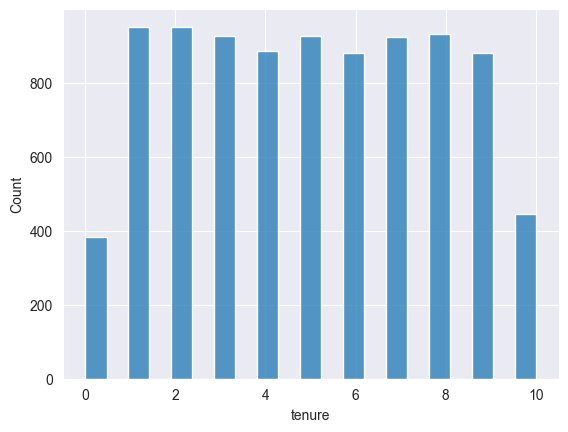

In [15]:
sns.histplot(df, x='tenure');

In [16]:
df.query('tenure.notna()')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9994,800,France,Female,29,2.0,0.00,2,0,0,167773.55,0
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1


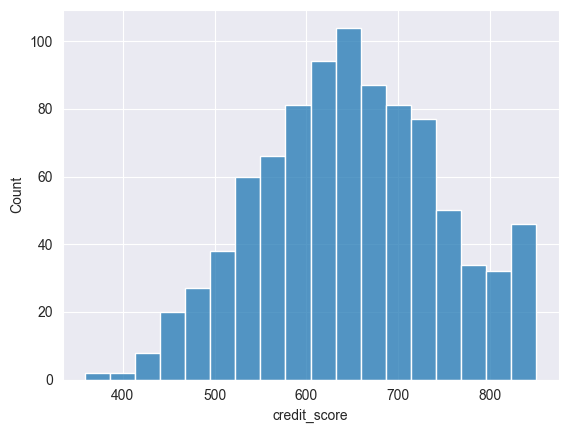

In [ ]:
for col in df.drop('tenure', axis=1).columns:
    sns.histplot(df.query('tenure.isna()'), x=col)
    plt.show()

Проанализировав распределения в значениях остальных переменных, когда в столбце `tenure` имеется пропуск, мы не обнаружили какой-то явной закономерности или изменения изначального распределения независимых переменных.

In [ ]:
features = df.select_dtypes(['float', 'integer']).query('tenure.notna()').drop('tenure', axis=1)
target = df.select_dtypes(['float', 'integer']).query('tenure.notna()')['tenure']
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25,
                                                                              random_state=42)

In [ ]:
np.random.seed(56)
np_pred = pd.Series(np.random.randint(0, 11, len(target_valid)))
df.loc[df['tenure'].isna(), 'tenure'] = np.random.randint(0, 11, len(df[df['tenure'].isna()]))
accuracy_score(target_valid, np_pred)

In [ ]:
df.tenure.value_counts()

In [ ]:
sns.histplot(df, x='tenure');

In [ ]:
df.tenure.std()

Заполнив пропущенные значения случайным числом в диапазоне от 0 до 10 включительно, мы получили незначительное увеличение параметра стандартного отклонения на 0.03. Точность заполнения по параметру accuracy составляет всего 0.103, метод ближайших соседей (KNN) дает близкий результат (~0.12+), поэтому остановимся на варианте использования случайных значений.

---
### *Изменение типов данных*

In [ ]:
df.tenure = df.tenure.astype('int8')
df.dtypes

In [ ]:
fcols = df.select_dtypes('float').columns
icols = df.select_dtypes('integer').columns

df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

In [ ]:
df.dtypes

Типы данных успешно преобразованы.

---
### *Обработка аномальных значений*

В данных могут встречаться артефакты (аномалии) — значения, которые не отражают действительность и появились по какой-то ошибке.

In [ ]:
(
    df[df.select_dtypes(['float', 'integer']).columns]
    .quantile([0.0012, 0.01, .5, .99, .9988])  # выбираем размах в 0,9976 квантилей
    .style.format("{:,.2f}")
)

Все количественные данные проходят проверку на адекватность, аномальных выбросов не обнаружено.

## Исследование задачи

Проверка независимых переменных на мультиколлинеарность.

In [ ]:
matrix = np.triu(df.drop('exited', axis=1).corr())
sns.heatmap(df.drop('exited', axis=1).corr(), annot=True, mask=matrix, cmap='coolwarm', linewidths=0.1,
            linecolor='black');

In [ ]:
g = sns.pairplot(df, hue='exited', kind='reg', plot_kws={'line_kws': {'color': 'red'}, 'scatter_kws': {'alpha': 0.1}})

Не обнаружено корреляций независимых признаков со значениями, превышающими показатель 0.7-0.8.
Оценим дисбаланс целевого класса в исходном df.

In [ ]:
df.exited.value_counts()

Количество значений целевого класса 0 в 4 раза превышеает количество значений целевого класса 1.

In [ ]:
df.head()

In [ ]:
features = df.drop('exited', axis=1)
target = df['exited']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42)

In [ ]:
num_columns = features.select_dtypes(exclude='object').drop(['has_cr_card', 'is_active_member'], axis=1).columns
obj_columns = features.select_dtypes(include='object').columns

Преобразуем категориальные данные методом OHE/прямое кодирование, так как в наших категориальных данных отсутствует какой-либо порядок значений.

In [ ]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
encoder_ohe.fit(features_train[obj_columns])
pd.options.mode.chained_assignment = None
features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[obj_columns])
features_train = features_train.drop(obj_columns, axis=1)
features_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test[obj_columns])
features_test = features_test.drop(obj_columns, axis=1)

Произведем масштабирование количественных признаков, для возможности построения моделей прогнозирования, таких как линейная регрессия, метод KNN(те модели, где масштаб признаков имеет значение).

In [ ]:
scaler = StandardScaler()
features_train[num_columns] = scaler.fit_transform(features_train[num_columns])
features_test[num_columns] = scaler.transform(features_test[num_columns])

Выберем модель, на основе которой будем получать наиболее точные результаты. Сравним модели пока без определения наилучших гиперпараметров.

In [ ]:
# Логистическая регрессия
model = LogisticRegression(solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
pred = model.predict(features_test)
f1_score(target_test, pred)

In [ ]:
# Логистическая регрессия
model = DecisionTreeClassifier(random_state=42)
params = {
    'min_samples_leaf': list(range(1, 8)),
    'min_samples_split': list(range(2, 8)),
    'class_weight': ['balanced', None],
    'max_depth': list(range(4, 12)),
    'random_state': [42]
}
decision_model = RandomizedSearchCV(model, param_distributions=params, random_state=42, cv=5, n_jobs=-1,
                                    scoring='f1').fit(features_train, target_train)
decision_model.best_score_
# decision_model.best_params_

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
params = {
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': list(range(1, 8)),
    'min_samples_split': list(range(2, 8)),
    'class_weight': ['balanced', None],
    'max_depth': list(range(4, 12)),
    'random_state': [42]
}
forest_model = RandomizedSearchCV(model, param_distributions=params, random_state=42, cv=5, n_jobs=-1,
                                  scoring='f1').fit(features_train, target_train)
forest_model.best_score_
# decision_model.best_params_

In [ ]:
forest_model.best_params_

Получили результат, что лучшие результаты выдает модель Случайного леса со значением F1 меры 0.622 до восстановления дисбаланса классов целевой переменной. Такого показателя удалось добиться используя вес классов, значение было установлено на `balanced`, что позволило  при расчете минимизировать эмпирический риск с учетом имеющегося дисбаланса классов. Ошибки возникают по причине того, что подбор гиперпараметров происходил на основании F1 меры и из свойств расчета этой оценки возможно получение значений nan.

Проведем подбор наилучших гиперпараметров без учета весов каждого из классов.

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
params = {
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': list(range(1, 8)),
    'min_samples_split': list(range(2, 8)),
    'class_weight': [None],
    'max_depth': list(range(4, 12)),
    'random_state': [42]
}
example_model = RandomizedSearchCV(model, param_distributions=params, random_state=42, cv=5, n_jobs=-1,
                                   scoring='f1').fit(features_train, target_train)
example_model.best_score_

Получили куда более слабый результат f1 меры.

## Борьба с дисбалансом

Первым методом обозначим уже использованный нами метод взвешивания классов.

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
params = {
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': list(range(1, 8)),
    'min_samples_split': list(range(2, 8)),
    'class_weight': ['balanced'],
    'max_depth': list(range(4, 12)),
    'random_state': [42]
}
forest_model = RandomizedSearchCV(model, param_distributions=params, random_state=42, cv=5, n_jobs=-1,
                                  scoring='f1').fit(features_train, target_train)
forest_model.best_score_

Попробуем осуществить другой способ борьбы с дисбалансом методом увеличения количества объектов класса 1 методом Upsampling.

In [ ]:
pipeline = Pipeline([("sm", SMOTE()), ('clf', RandomForestClassifier(n_estimators=10, random_state=42))])
params = {
    'clf__n_estimators': [50, 100, 200],
    'clf__min_samples_leaf': list(range(1, 8)),
    'clf__min_samples_split': list(range(2, 8)),
    'clf__max_depth': list(range(4, 12)),
    'clf__random_state': [42]
}

r_search = RandomizedSearchCV(pipeline, param_distributions=params, cv=5, scoring='f1',
                              return_train_score=True).fit(features_train, target_train)
r_search.best_score_

Попробуем осуществить другой способ борьбы с дисбалансом методом Downsampling.

In [ ]:
pipeline = Pipeline(
    [("rnd_us", RandomUnderSampler()), ('clf', RandomForestClassifier(n_estimators=10, random_state=42))])
params = {
    'clf__n_estimators': [50, 100, 200],
    'clf__min_samples_leaf': list(range(1, 8)),
    'clf__min_samples_split': list(range(2, 8)),
    'clf__max_depth': list(range(4, 12)),
    'clf__random_state': [42]
}

r_search = RandomizedSearchCV(pipeline, param_distributions=params, cv=5, scoring='f1',
                              return_train_score=True).fit(features_train, target_train)
r_search.best_score_

Получили еще более слабый результат.

Оценим топ-3 набора гиперпараметров для наилучшей модели, учитывающей дисбаланс классов.

In [ ]:
results = forest_model.cv_results_
top_n = 3
top_indices = sorted(range(len(results['params'])), key=lambda i: results['mean_test_score'][i], reverse=True)[:top_n]
for i in top_indices:
    print(f"Rank: {top_indices.index(i)+1}")
    print(f"Mean test F1-score: {results['mean_test_score'][i]}")
    print(f"Hyperparameters: {results['params'][i]}")
    print("========================================")

Если стоит вопрос быстродействия, то разумным решением будет взять и применять 3 набор гиперпараметров.

## Подбор порогового значения классификатора для улучшения параметра Recall.

In [ ]:
best_model = RandomForestClassifier(**forest_model.best_params_).fit(features_train, target_train)
prob = forest_model.predict_proba(features_train)[:, 1]

fpr, tpr, thresholds = roc_curve(target_train, prob)
plt.plot(fpr, tpr, label='ROC Curve')
plt.grid(True)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.title('ROC кривая для наилучшей модели случайного леса');

In [ ]:
max_recall_threshold = 0
max_f1_value = 0
max_recall = 0
best_y_predict = 0
auc_roc = 0
for i in range(len(thresholds)):
    y_pred = prob >= thresholds[i]
    recall = recall_score(target_train, y_pred)
    f1_value = f1_score(target_train, y_pred)
    auc_roc_current = roc_auc_score(target_train, y_pred)
    if recall > max_recall and f1_value > max_f1_value:
        max_recall = recall
        max_recall_threshold = thresholds[i]
        max_f1_value = f1_value
        best_y_predict = y_pred
        auc_roc = auc_roc_current

# Выводим полученные результаты
print("Оптимальный пороговый коэффициент: {:.3f}".format(max_recall_threshold))
print("Значение Recall: {:.3f}".format(max_recall))
print("Значение F1: {:.3f}".format(max_f1_value))
print("Значение ROC_AUC: {:.3f}".format(auc_roc))

Произведен подбор оптимального порогового коэффициента на тестовой выборке, который равен 0.517.

## Тестирование лучшей модели.

In [ ]:
prob_test = forest_model.predict_proba(features_test)[:, 1] >= 0.517
print("Значение Recall: {:.3f}".format(recall_score(target_test, prob_test)))
print("Значение F1: {:.3f}".format(f1_score(target_test, prob_test)))
print("Значение ROC_AUC: {:.3f}".format(roc_auc_score(target_test, prob_test)))

Получили F1 меру со значением 0.633, что совпадает практически с лучшим значением полученным на тренировочных данных на кросс-валидационном тестировании. Значение Recall в 0.678 и значение ROC_AUC 0.781, которое незначительно уступает значению, полученному на тренировочных данных.

In [ ]:
target_test.value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7), dpi=100)
cm = confusion_matrix(target_test, prob_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])
cmp.plot(ax=ax, cmap='coolwarm');

Проанализировав матрицу ошибок мы видим наличие FN ответов от нашей модели, а так как каждый прогноз нашей модели есть некоторая вероятность нашего объекта относиться к одному из классов, то мы можем в дальнейшем корректировать пороговое значение, если это будет необходимо, для дальнейшего повышения метритки Recall, если того будут требовать задачи бизнеса. Это приведет конечно к постепенному снижению значения F1 score.

---
## Общий вывод по исследованию

<div style="border:solid orange 2px; padding: 5px">

<div class="alert alert-info"> <b>При проведении исследования (на основе полученных данных) выполнено:</b></div>

- Данные подготовлены к дальнейшему использованию при построении моделей.
- Произведено восстановление 9 % пропущенных значений в столбце `tenure`.
- Произведена оптимизация формата размерности количественных данных.
- Проведена проверка отсутствия мультиколлинеарности независимых признаков.
- Два независимых категориальных признака преобразованы методом OHE для дальнейшей работы.
- Произведено масштабирование независимых количественных признаков, которые имели большой разброс значений.
- Выбрана модель с наилучшей предсказательной способностью для решения задачи бинарной классификации зависимого признака.
- На данной модели протестированы различные методы борьбы с дисбалансом классов в целевом признаке. Выбран наилучший метод.
- Для выбранной модели осуществлен подбор наилучших гиперпараметров, также выбраны альтернативные гиперпараметры, если будет принято решение немного пожертвовать величиной F1 меры в пользу быстродействия исполнения.
- Произведен подбор на тренировочной выборке оптимального порогового значения для достижения наибольшего показателя Recall и F1 меры, thresholds - 0.517.
- Проведено тестирование модели на тестовой выборке.
-  На тестовой выборке получены следующие результаты: показатель Recall 0.678, удалось добиться предсказательной способности модели на метрике F1 равной 0.633. Показатель значения качества модели ROC_AUC при заданном пороге получился равен 0.781.